In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(32)
df = pd.read_csv('./Data/data_ex_labeled.csv')
# test = df[81000:-1] # test set
# df = df[:80000] # training set

In [18]:
X = df.loc[:, "store_A":"predecessors_B"]
Y = df['output']
Y = Y.replace(0, -1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=33)
print(type(X_train), type(y_train))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [4]:
X_A = X_train[['store_A','put_A','wrtmp_A','loadg_A','storeg_A','cas_A','sucessors_A','predecessors_A']]
X_B = X_train[['store_B','put_B','wrtmp_B','loadg_B','storeg_B','cas_B','sucessors_B','predecessors_B']]

In [5]:
X_A_val = X_A.values
X_B_val = X_B.values
Y_val = y_train.values

In [6]:
X_A_val = torch.FloatTensor(X_A_val)
X_B_val = torch.FloatTensor(X_B_val)
Y_val = torch.FloatTensor(Y_val)

In [7]:
class Model(nn.Module):
    def __init__(self, ins=8, h1=15, h2=10, outs=8):
        super().__init__()
        self.fc1 = nn.Linear(ins,h1)    
        self.fc2 = nn.Linear(h1, h2)    # hidden layer
        self.out = nn.Linear(h2, outs)  
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [8]:
model = Model()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 400
losses = []
#cos = nn.CosineSimilarity(dim=1, eps=1e-6)
loss = torch.nn.CosineEmbeddingLoss()

for i in range(epochs):
    # Forward and get a prediction
    
    X_A_out = model.forward(X_A_val)
    X_B_out = model.forward(X_B_val)
    
    output = loss(X_A_out, X_B_out, Y_val)

    # record loss
    losses.append(output)
    
    if i%20==0:
        print(f'epoch {i}: {output}')
    
    optimizer.zero_grad()
    output.backward()
    optimizer.step()
    

epoch 0: 0.9924860596656799
epoch 20: 0.7238149046897888
epoch 40: 0.49285075068473816
epoch 60: 0.5209597945213318
epoch 80: 0.47690215706825256
epoch 100: 0.41596555709838867
epoch 120: 0.3754385709762573
epoch 140: 0.35425645112991333
epoch 160: 0.34657418727874756
epoch 180: 0.3397194743156433
epoch 200: 0.3331352174282074
epoch 220: 0.28905588388442993
epoch 240: 0.27942779660224915
epoch 260: 0.26440876722335815
epoch 280: 0.25761476159095764
epoch 300: 0.25762033462524414
epoch 320: 0.24660523235797882
epoch 340: 0.25798162817955017
epoch 360: 0.2423747330904007
epoch 380: 0.24770431220531464


Text(0.5, 0, 'Epoch')

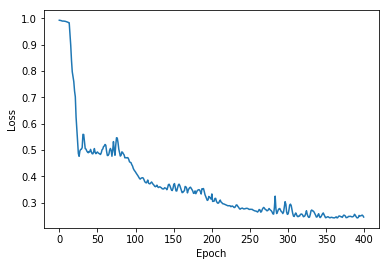

In [11]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [17]:
test_A = torch.FloatTensor(X_test[['store_A','put_A','wrtmp_A','loadg_A','storeg_A','cas_A','sucessors_A','predecessors_A']].values)
test_B = torch.FloatTensor(X_test[['store_B','put_B','wrtmp_B','loadg_B','storeg_B','cas_B','sucessors_B','predecessors_B']].values)
test_val = torch.LongTensor(y_test.values)
# test_A[0]
# A_val = model.forward(test_A[0])
# B_val = model.forward(test_B[0])
# cos_s = nn.CosineSimilarity(dim=0, eps=1e-8)
# print(A_val, B_val)
# o = cos_s(A_val, B_val)
# print(o)
# print(test_val[0])
# with torch.no_grad():
#     eval_A = model.forward(test_A)
#     eval_B = model.forward(test_B)
#     loss = loss(eval_A, eval_B, test_val)
cos_s = nn.CosineSimilarity(dim=1, eps=1e-8)
with torch.no_grad():
    A_val = model.forward(test_A)
    B_val = model.forward(test_B)
    similarity = cos_s(A_val, B_val)
    
    # clone if similarity greater than 0
    result = torch.LongTensor([-1 if x<0 else 1 for x in similarity])
    # print(test_val)
    print(similarity)
    # print(result)
    correct = (result == test_val)
    # print(correct)
    print(f'Total: {len(test_val)}, Correct: {int(correct.sum())}, rate: {float(correct.sum())/len(test_val)}')

tensor([-0.1085, -0.3157, -0.2911,  ..., -0.5946, -0.1647,  0.4285])
Total: 17598, Correct: 12330, rate: 0.7006478008864644


In [13]:
'''
    gcc_coreutils8.31_O2_chown,2819,18959,30284,0,0,0,4757,4757,
    gcc_coreutils8.31_O0_chown,3367,18956,34256,0,0,0,4851,4851,
    1
    
    gcc_coreutils8.31_O3_chroot,3182,17628,23406,0,0,0,3342,3342,
    gcc_coreutils8.31_O0_mknod,1801,9061,16011,0,0,0,2143,2143,
    0
    
''' 
cos_s = nn.CosineSimilarity(dim=0, eps=1e-8)
test_data_clone = torch.Tensor([[2819, 18959, 30284, 0, 0, 0, 4757, 4757], [3367,18956,34256,0,0,0,4851,4851]])
test_data_not_clone = torch.Tensor([[3182,17628,23406,0,0,0,3342,3342], [1801,9061,16011,0,0,0,2143,2143]])
with torch.no_grad():
    clone_output_A = model.forward(test_data_clone[0])
    clone_output_B = model.forward(test_data_clone[1])
    clone_output = cos_s(clone_output_A, clone_output_B)
    #print(f'{clone_output_A} \n {clone_output_B} \n {clone_output}')
    print(clone_output)


    not_clone_output_A = model.forward(test_data_not_clone[0])
    not_clone_output_B = model.forward(test_data_not_clone[1])
    not_clone_output = cos_s(not_clone_output_A, not_clone_output_B)
    #print(f'{not_clone_output_A} \n {not_clone_output_B} \n {not_clone_output}')
    print(not_clone_output)

tensor(-0.9247)
tensor(-0.1452)


In [17]:
print(model.parameters())
for param in model.parameters():
    # print weight
    print(param.data)

<generator object Module.parameters at 0x7f0755784048>
tensor([[ 0.2656, -0.1612, -0.0608,  0.2020, -0.2737,  0.0561,  0.1047, -0.3374],
        [ 0.0740, -0.1245,  0.3212,  0.0155,  0.2674,  0.1594,  0.1380, -0.3337],
        [ 0.2910, -0.3042,  0.1378,  0.1606, -0.0023,  0.3046, -0.1083, -0.2234],
        [ 0.1164, -0.0787, -0.2979, -0.2513, -0.2257,  0.1018, -0.2472,  0.1612],
        [ 0.2679, -0.1334,  0.2104,  0.0074,  0.2254, -0.0446, -0.2078,  0.2803],
        [-0.2050,  0.0802,  0.2049, -0.2559, -0.3214,  0.1976, -0.3475, -0.2620],
        [ 0.1484, -0.1373,  0.2292, -0.0764,  0.0569, -0.1953,  0.0511, -0.3453],
        [-0.2689, -0.2716,  0.0416, -0.0628,  0.3519,  0.0132,  0.3048, -0.2101],
        [ 0.0755, -0.0588,  0.3173,  0.1180,  0.0254, -0.2260, -0.3011, -0.1137],
        [ 0.1822, -0.1912, -0.1485, -0.3094,  0.3335,  0.3195, -0.2034,  0.0114],
        [-0.0197,  0.0627, -0.2298, -0.2206, -0.0519, -0.2718,  0.0394, -0.1808],
        [-0.2795, -0.0174, -0.1481,  0.1461